## STOCK PREDICTION MODEL = *TOMORROW UP OR DOWN*

-  Stock used en the model = PA (Principal Asset) Any asset
-  Direct Variable used in the model = CA (Correlated Asset) find an asset that have a directo correlation with the PA

In [1]:
import sys
print("Ambiente activo:", sys.executable)

Ambiente activo: /opt/anaconda3/envs/midterm-py311/bin/python


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
#import xgboost as xgb

In [9]:
pa_ticker = input("Por favor, digita el Ticker del Activo Principal (ej: EC): ") # Principal Asset
ca_ticker = input("Por favor, digita el Ticker del Activo Correlacionado (ej: CL=F): ") # Correlated Asset

Por favor, digita el Ticker del Activo Principal (ej: EC):  CIB
Por favor, digita el Ticker del Activo Correlacionado (ej: CL=F):  XLF


In [10]:
# Doownload the Principal Asset (PA)
print(f"Downloading principal asset: {pa_ticker}...") # Replace pa_ticker for Principal Asset TICKET
df = yf.download(pa_ticker, period="5y", interval="1d", progress=False, auto_adjust=False)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df.columns = [f'{pa_ticker}_Open', f'{pa_ticker}_High', f'{pa_ticker}_Low', f'{pa_ticker}_Close', f'{pa_ticker}_Volume']
print(f"Principal asset: {len(df)} filas")

# =============================
# Download correlated Asset (CA)
print(f"Downloading correlated asset: {ca_ticker}...") # Replace pa_ticker for correlated Asset TICKET
ca_df = yf.download(ca_ticker, period="5y", interval="1d", progress=False, auto_adjust=False)
ca_df = ca_df[['Open', 'High', 'Low', 'Close', 'Volume']]

ca_df.columns = [f'{ca_ticker}_Open', f'{ca_ticker}_High', f'{ca_ticker}_Low', f'{ca_ticker}_Close', f'{ca_ticker}_Volume']

print(f"Correlated asset downloaded: {len(ca_df)} filas")

print(f"Columns principal asset download:", df.columns.tolist())

Failed to get ticker 'CIB' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['CIB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Principal asset: 0 filas


Failed to get ticker 'XLF' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['XLF']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Correlated asset downloaded: 0 filas
Columns principal asset download: ['CIB_Open', 'CIB_High', 'CIB_Low', 'CIB_Close', 'CIB_Volume']


In [5]:
# Adaptation and align of assets

# --- 1. Aling and  Estandarization of  CA ---

df['CA_Close'] = ca_df[f'{ca_ticker}_Close'].reindex(df.index).ffill() 
df['CA_Open'] = ca_df[f'{ca_ticker}_Open'].reindex(df.index).ffill()
df['CA_High'] = ca_df[f'{ca_ticker}_High'].reindex(df.index).ffill()
df['CA_Low'] = ca_df[f'{ca_ticker}_Low'].reindex(df.index).ffill()
df['CA_Volume'] = ca_df[f'{ca_ticker}_Volume'].reindex(df.index).ffill()


# --- 2. Estandarización de PA ---
# Built generic columns of the Principal Asset (PA) in df 

df['PA_Open'] = df[f'{pa_ticker}_Open']
df['PA_High'] = df[f'{pa_ticker}_High']
df['PA_Low'] = df[f'{pa_ticker}_Low']
df['PA_Close'] = df[f'{pa_ticker}_Close']
df['PA_Volume'] = df[f'{pa_ticker}_Volume']

# Delete rows with NaN after the alignment.
df = df.dropna()

print(f"Align DataFrames. Final rows: {len(df)}")

Align DataFrames. Final rows: 0


In [6]:
#  - Built Features 
df['CA_Change'] = df['CA_Close'].pct_change()
df['PA_CA_Ratio'] = df['PA_Close'] / (df['CA_Close'] + 1e-8)
df['CA_Volatility'] = df['CA_Close'].rolling(14).std()

print("\nFeatures of correlated asset builts correctly.")
print(df[['PA_Close', 'CA_Close', 'PA_CA_Ratio']].head(3))


ValueError: attempt to get argmax of an empty sequence

In [7]:
#Rename to ML
df['Close'] = df['PA_Close']  
df['Volume'] = df['PA_Volume']

#Tecnical Features (SMA, RSI, etc.)
df['SMA_100'] = df['Close'].rolling(100).mean()

In [8]:
# Definition of RSI function

def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rs = rs.replace([np.inf, -np.inf], np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'])

#New technical Features

df['Overbought'] = (df['RSI_14'] > 70).astype(int)
df['Oversold'] = (df['RSI_14'] < 30).astype(int)
df['Below_SMA'] = (df['Close'] < df['SMA_100']).astype(int)
df['High_Volume'] = (df['Volume'] > df['Volume'].rolling(20).mean()).astype(int)

In [32]:
#Variable Target
df['Tomorrow_Close'] = df['Close'].shift(-1)
df['Target'] = (df['Tomorrow_Close'] < df['Close']).astype(int)  # 1 = baja

In [33]:
# Final list of Features
features = [
    'Close', 'Volume', 'SMA_100', 'RSI_14',
    'Overbought', 'Oversold', 'Below_SMA', 'High_Volume',
    'CA_Close', 'CA_Change', 'PA_CA_Ratio', 'CA_Volatility'
]  

In [34]:
#DATAFRAME To ML
df_ml = df[features + ['Target']].copy()
df_ml = df_ml.dropna().reset_index(drop=True)
print(f"\nFinal rows to ML: {len(df_ml)}")
print(f"Correlation PA - CA: {df['Close'].corr(df['CA_Close']):.3f}")


Final rows to ML: 1157
Correlation PA - CA: 0.432


In [35]:
print(df[['Close', 'CA_Close']].head(3))

            Close   CA_Close
Date                        
2020-11-12  10.78  41.119999
2020-11-13  10.99  40.130001
2020-11-16  11.67  41.340000


 EXPLORATORY DATA ANÁLISYS (EDA)


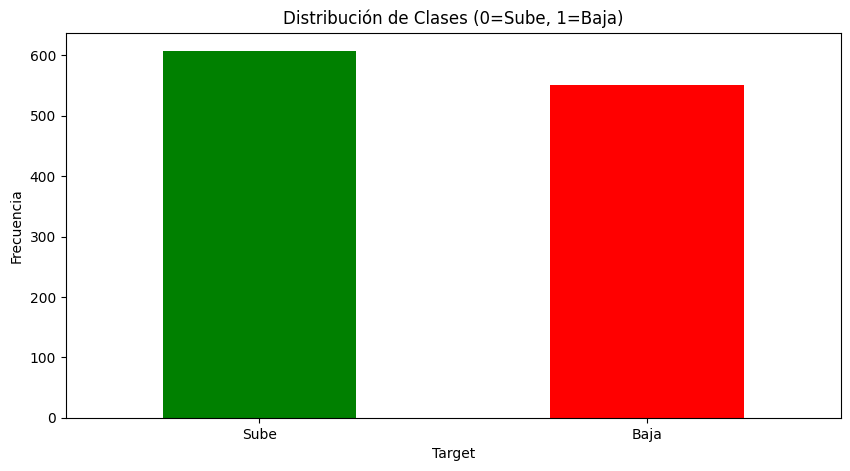

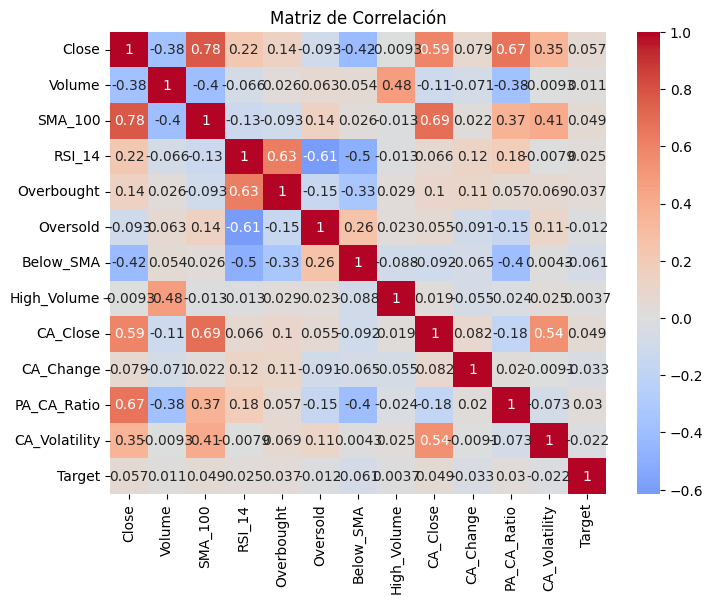

In [36]:
# --- 5. EDA ---
print(" EXPLORATORY DATA ANÁLISYS (EDA)")

# Distributión of target

plt.figure(figsize=(10,5))
df_ml['Target'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribución de Clases (0=Sube, 1=Baja)')
plt.xticks([0,1], ['Sube', 'Baja'], rotation=0)
plt.ylabel('Frecuencia')
plt.show()

# Correlación
plt.figure(figsize=(8,6))
sns.heatmap(df_ml[features + ['Target']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

In [37]:
#DIVISIÓN TRAIN/TEST ---
X = df_ml[features]
y = df_ml['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # ¡Importante: serie temporal!
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}\n")

Train: 925 | Test: 232



In [38]:
#Baseline Model ---
baseline_acc = max(y_test.value_counts()) / len(y_test)
print(f"Baseline (majority prediction): {baseline_acc:.3f}\n")

Baseline (majority prediction): 0.565



In [39]:
#Train  Multiples Models ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.3f}")


/opt/anaconda3/envs/midterm-py311/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Logistic Regression: 0.565
Random Forest: 0.534
KNN: 0.530
XGBoost: 0.552


In [40]:
#Train and Compare 4 MODELS ---
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.3f}")

#Best Model ---
best_name = max(results, key=results.get)
best_model = models[best_name]
print(f"\nBest Model: {best_name} → {results[best_name]:.3f}")

Logistic Regression: 0.565
Random Forest: 0.534
KNN: 0.530
XGBoost: 0.552

Best Model: Logistic Regression → 0.565



Classification Report:
              precision    recall  f1-score   support

        Sube       0.56      1.00      0.72       131
        Baja       0.00      0.00      0.00       101

    accuracy                           0.56       232
   macro avg       0.28      0.50      0.36       232
weighted avg       0.32      0.56      0.41       232



/opt/anaconda3/envs/midterm-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average=average,
/opt/anaconda3/envs/midterm-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average=average,
/opt/anaconda3/envs/midterm-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average=average,


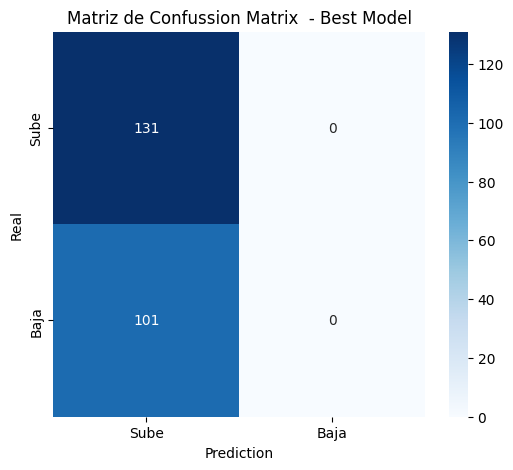

In [41]:
# Detail Evaluation 
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Sube', 'Baja']))

#Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sube', 'Baja'], yticklabels=['Sube', 'Baja'])
plt.title('Matriz de Confussion Matrix  - Best Model')
plt.ylabel('Real')
plt.xlabel('Prediction')
plt.show()

In [42]:
#To save model
os.makedirs('data', exist_ok=True)
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(features, 'data/features.pkl')
print("\nModel saved as 'best_model.pkl'")


Model saved as 'best_model.pkl'


In [ ]:
#Export Data
df_ml.to_csv('data/PA_processed.csv', index=True)
print("Processed data save in 'data/PA_processed.csv'")

In [ ]:
print("Columns in original df:", df.columns.tolist())
print("Columns in df_ml:", df_ml.columns.tolist())
print("Rows in df_ml after of dropna:", len(df_ml.dropna()))

In [ ]:
# See Distribution of classes

print("Distribución en TEST:")
print(y_test.value_counts(normalize=True).round(3))

#Models results
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc:.3f}")

In [ ]:
# To Save data in container
df_ml.to_csv('data/df_ml.csv', index=False)
print("Datos guardados en data/df_ml.csv")

In [ ]:
# Proof of testing list of features
import joblib
features = joblib.load('data/features.pkl')
print(features)

In [ ]:
# ===============================================
# Generate Predictions With The Model
# ===============================================

import joblib
import pandas as pd

# --- Upload Model And Features  ---
model = joblib.load('best_model.pkl')
features = joblib.load('data/features.pkl')

print(f"Model upload: {type(model).__name__}")
print(f"Features expected ({len(features)}): {features}")

# --- Verify That "df" Has All Features ---
missing = [f for f in features if f not in df.columns]
if missing:
    print(f"ERROR: Faltan columnas: {missing}")
else:
    print("All features are presents")
# This line let manage the NaN values in X    
df.dropna(subset=features, inplace=True)

# --- Generate Predictions ---
X = df[features]  # Only columns that The Model Needs
df['prediction'] = model.predict(X)

# --- Verify ---
print(f"\nPredictions output: {len(df)} filas")
print("Distribution of Predictionts:")
print(df['prediction'].value_counts().sort_index())

# Example: last 5 predictions
print("\nLast five (5) predictions:")
print(df[['PA_Close', 'Tomorrow_Close', 'Target', 'prediction']].tail())

In [ ]:
# ===============================================
# 17. BACKTEST 2 YEARS: BUY vs SELL (SHORT SELL)
# ===============================================

import numpy as np
import matplotlib.pyplot as plt

print("Starting comparative backtest ...")

# --- Prepair Data ---
df_backtest = df.copy()
df_backtest = df_backtest.sort_index()
end_date = df_backtest.index[-1]
start_date = end_date - pd.Timedelta(days=730)
df_backtest = df_backtest[df_backtest.index >= start_date].copy()

df_backtest = df_backtest.dropna(subset=['prediction', 'Tomorrow_Close', 'PA_Close'])
df_backtest['daily_return'] = (df_backtest['Tomorrow_Close'] - df_backtest['PA_Close']) / df_backtest['PA_Close']

# --- Estrategy 1: Buy if Predict PA Will Up Tomorrow ---
df_backtest['buy_return'] = np.where(df_backtest['prediction'] == 0, df_backtest['daily_return'], 0)
trades_buy = df_backtest[df_backtest['prediction'] == 0]
win_buy = len(trades_buy[trades_buy['daily_return'] > 0])
win_rate_buy = win_buy / len(trades_buy) if len(trades_buy) > 0 else 0
total_buy = (1 + df_backtest['buy_return']).prod() - 1

# --- Estrategy 2: Sell Short If Predict PA Down Tomorrow ---
df_backtest['sell_return'] = np.where(df_backtest['prediction'] == 1, -df_backtest['daily_return'], 0)
trades_sell = df_backtest[df_backtest['prediction'] == 1]
win_sell = len(trades_sell[trades_sell['daily_return'] < 0])
win_rate_sell = win_sell / len(trades_sell) if len(trades_sell) > 0 else 0
total_sell = (1 + df_backtest['sell_return']).prod() - 1

# --- Graphs ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

cum_buy = (1 + df_backtest['buy_return']).cumprod()
ax1.plot(cum_buy, label='buy if up', color='green', linewidth=2)
ax1.set_title(f'Buy if predict up | Return: {total_buy:.1%} | Win rate: {win_rate_buy:.1%}')
ax1.set_ylabel('Growth')
ax1.legend()
ax1.grid(True, alpha=0.3)

cum_sell = (1 + df_backtest['sell_return']).cumprod()
ax2.plot(cum_sell, label='Sell short if down', color='red', linewidth=2)
ax2.set_title(f'Sell short if predict down | Return: {total_sell:.1%} | Win rate: {win_rate_sell:.1%}')
ax2.set_ylabel('Growth')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Final Table ---
print("\n" + "="*70)
print("BACKTEST COMPARATIVE - PA")
print("="*70)

win_rate_buy_str = f"{win_rate_buy:.1%}"
win_rate_sell_str = f"{win_rate_sell:.1%}"
total_buy_str = f"{total_buy:.1%}"
total_sell_str = f"{total_sell:.1%}"

print(f"{'Estrategy':<25} {'Trades':<8} {'Win rate':<10} {'Return total'}")
print("-"*70)
print(f"{'Buy if goes up':<25} {len(trades_buy):<8} {win_rate_buy_str:<10} {total_buy_str}")
print(f"{'Sell if down':<25} {len(trades_sell):<8} {win_rate_sell_str:<10} {total_sell_str}")
print("="*70)

In [1]:
# EN UNA CELDA DEL NOTEBOOK
import sys
import numpy as np
import sklearn

print("Python:", sys.version)
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)

Python: 3.11.14 (main, Oct 21 2025, 18:27:30) [Clang 20.1.8 ]
numpy: 1.24.3
sklearn: 1.3.2


In [44]:
import pandas as pd
print("pandas version:", pd.__version__)

pandas version: 2.3.3


In [45]:
pip show pandas

Name: pandas
Version: 2.1.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be u